<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/regression_drift_0516.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)

# 준비
+ synthetic data를 만든다.
+ 해당 data는 importance가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다. 

## synthetic data의 생성

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 importance

In [4]:
data_size = 40000
cor = [2.5, 2.0, 1.5 , 1.0, 0.5]

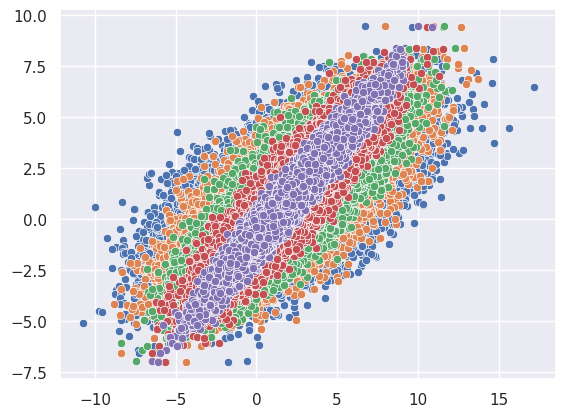

In [5]:
seed_everything()
y= np.random.normal(1,2,data_size)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

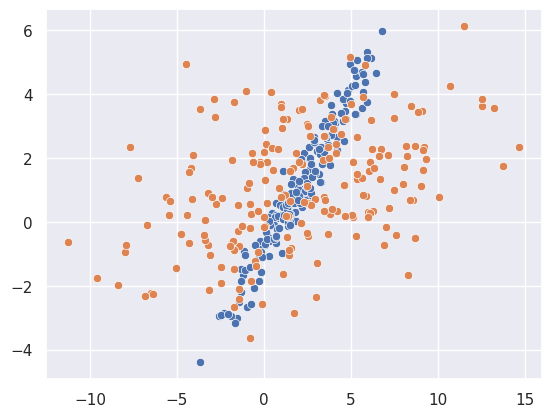

In [6]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## Mutual Information의 측정

In [7]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [8]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.810444
x2    0.512920
x1    0.350373
z0    0.255009
x0    0.238650
Name: MI Scores, dtype: float64


### Bucket 별 MI 측정

+ Bucket을 10, 50, 100 으로 나눠서

Bucket size 10


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


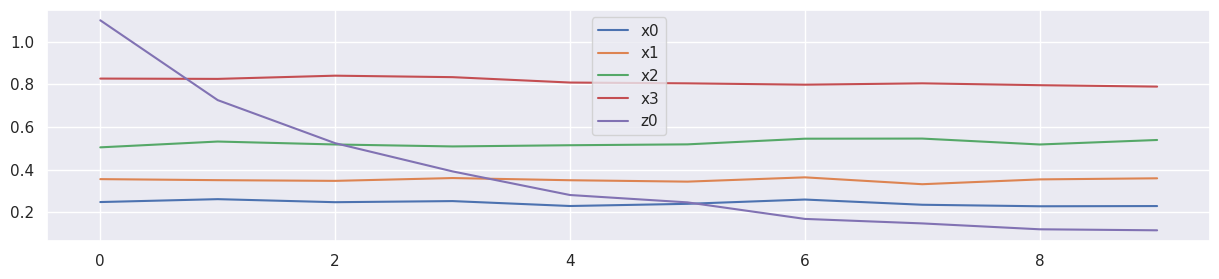

Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 37.39it/s]


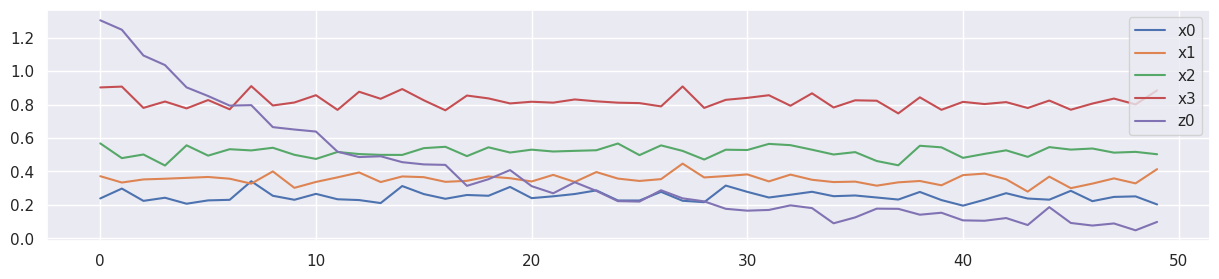

Bucket size 100


100%|██████████| 100/100 [00:01<00:00, 59.33it/s]


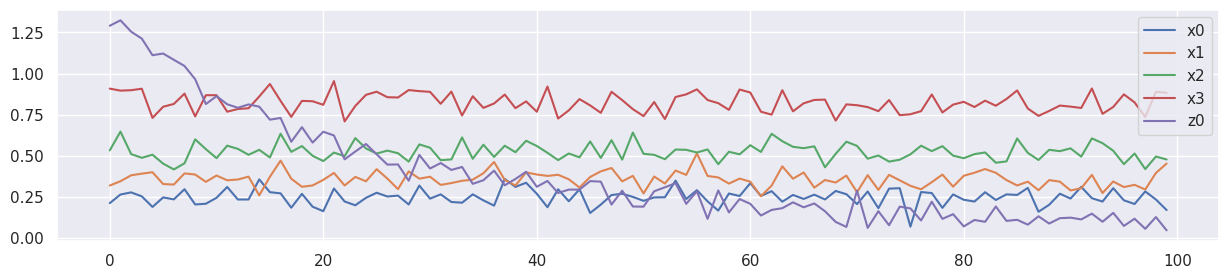

Bucket size 200


100%|██████████| 200/200 [00:03<00:00, 65.47it/s]


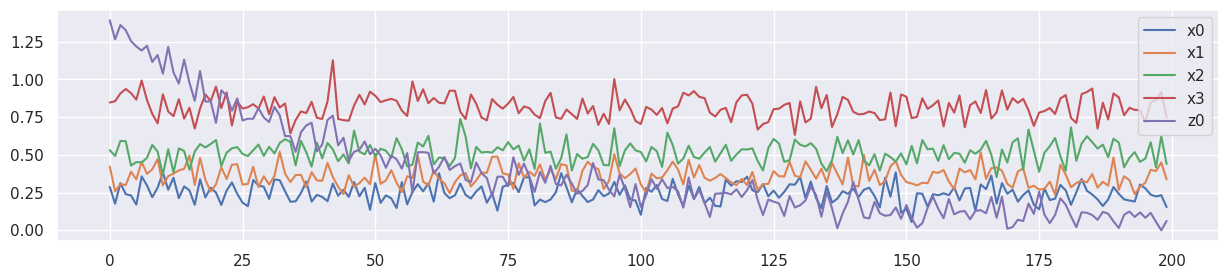

In [9]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*step_size:bk*step_size+step_size], y[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

+ 상기 실험에서, z0의 MI는 bucket의 증가에 따라, 낮아지는 것을 확인할 수 있다.

## ks-test 

In [10]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

Bucket size 10


100%|██████████| 10/10 [00:00<00:00, 287.75it/s]


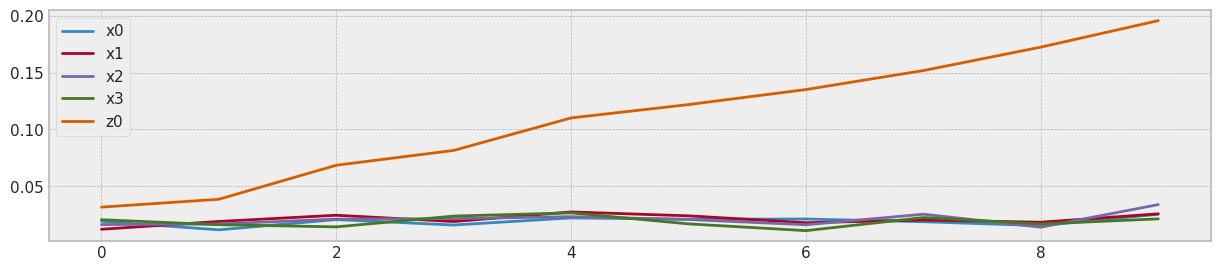

Bucket size 50


100%|██████████| 50/50 [00:00<00:00, 401.85it/s]


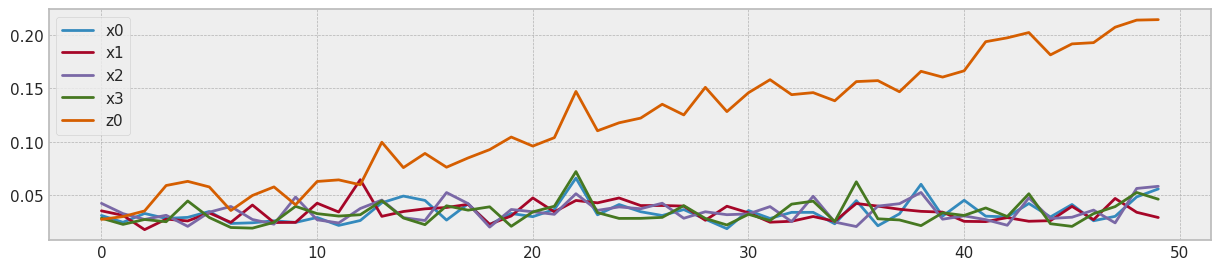

Bucket size 100


100%|██████████| 100/100 [00:00<00:00, 528.81it/s]


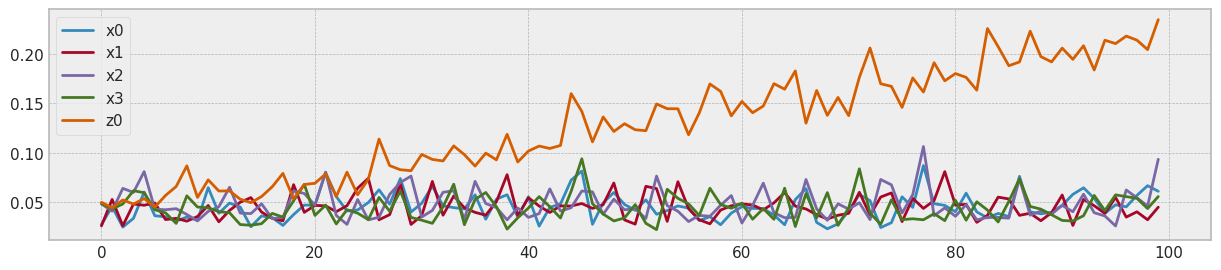

Bucket size 200


100%|██████████| 200/200 [00:00<00:00, 487.31it/s]


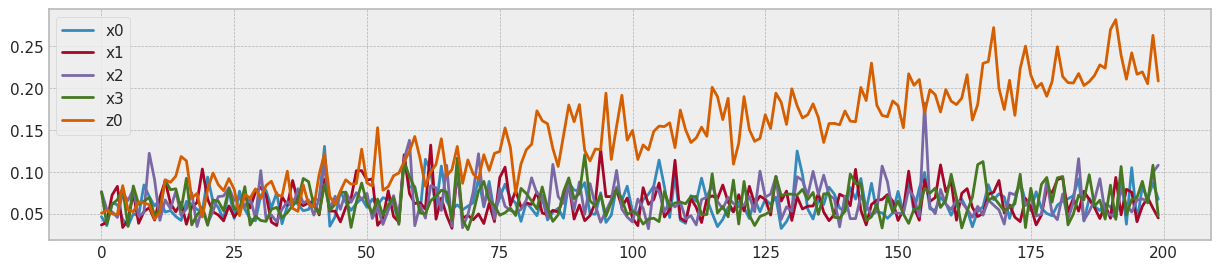

In [11]:

from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)

        ks = __ks_drift(X[0:1800].values,X[bk*step_size+2000:bk*step_size+step_size+2000].values)
        #print(ks[:,0])
        for ix,col in enumerate(columns):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

# Deep architecture에 의한 y의 추정 실험

+ 2000개를 학습하고, 이후 38000개를 추정한다.

## 학습데이터, 2000개 내 bucket 20개의 importance 변화

100%|██████████| 20/20 [00:00<00:00, 95.21it/s]


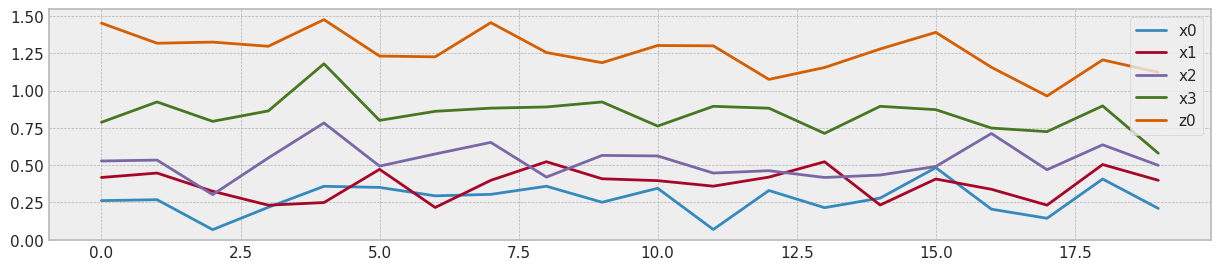

In [12]:
MIS = {}
for col in columns:
    MIS[col] = []
        
for bk in tqdm(range(20)):
    bx = X[bk*100:(bk+1)*100]
    by = y[bk*100:(bk+1)*100]
    mi_scores = make_mi_scores(bx, by, discrete_features="auto")
    for col in columns:
        MIS[col].append(mi_scores[col]) 

df_mis = pd.DataFrame(MIS)
df_mis.plot(figsize=(15,3))
plt.show()

## feature 5개를 모두 포함한 학습

100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


MSE: 0.27
RMSE: 0.52


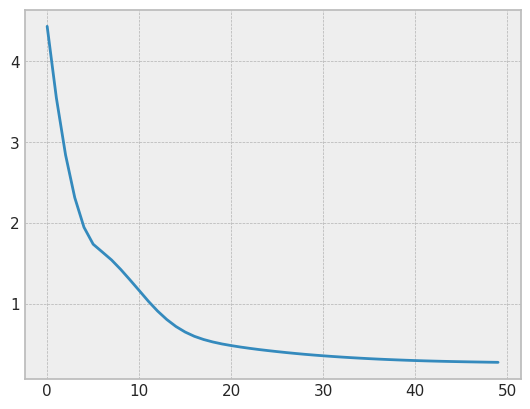

In [13]:
import copy
import torch.optim as optim
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

+ R2 측정

In [14]:
from sklearn.metrics import r2_score
predicted_y = model(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9340692206409946


+ 2000~40000까지의 R-squared score 측정 

100%|██████████| 190/190 [00:00<00:00, 1398.32it/s]


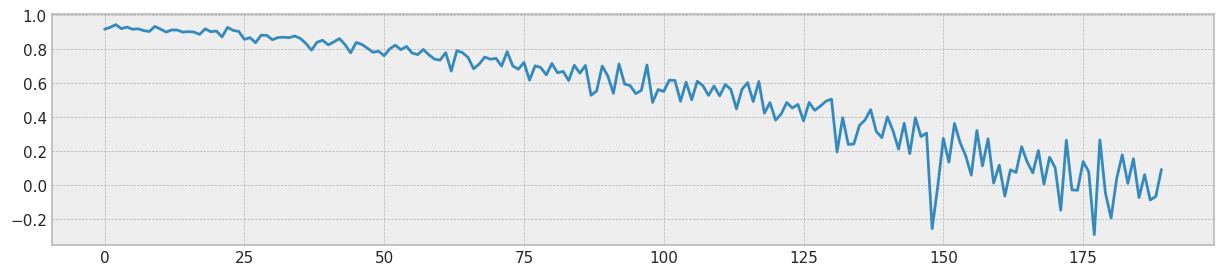

In [15]:
XT = X[2000:]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    r2s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        r2s.append(r2)
    plt.figure(figsize=(15,3))
    plt.plot(r2s)
    plt.show()
